In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules

# Shopping recommendation system, using Association Rules

## Introduction to association rules

Association rules are great with discovering relationships between analysed items. In case of market basket analysis this method is really useful in finding co-occurences of items in different orders, which later can be helpful during implemenation of recommendation systems on website. Obviously there are many different fields where association rules can be found. This include medicine (predicting ilnesses), entertainment (movie recommendation) or law enforcement (analysing suspects profile). 

Association rules are part of unsupervised learning branch of machine learning, where data is analysed to find patterns of occurences of two or more items. These patterns comprise of two parts:
 - antecedent - item found in analysed data;
 - consequent - item found to be in relationship with antecedent.

Then dataset is analysed for frequent relationships between items, with help of different criteria like supoport, confidence or lift.

<b>Support</b> is the frequency of given item in dataset, which is calculated by following: divide number of occurences of given item by total number of items in data.

<b>Confidence</b> is the probability of finding of item in a transaction, given that other item exists in transaction.

<b>Lift is how</b> importance of a rule is measured. It is the ratio of confidence and expected confidence. The higher the lift, the greater the probability of co-occurence of given items.

## Exploratory data analysis and preparation

Our dataset contains only 3 columns:
 - Member_number - unique number that identifies customer;
 - Date - date of the transaction;
 - itemDescription - name of purchased item.

At first there is one obvious problem - there is no unique transaction id, that would describe all available baskets in dataset. This is why, transaction id will be treated as combined value of member number and date -- assumption that every customer made maximum one purchase per day.

In [2]:
data = pd.read_csv("data/Groceries_dataset.csv", encoding="unicode-escape", sep=",")  # load the data
data.head()

,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk


### Basic information about dataset

In [3]:
print("Number of unique items:",  len(np.unique(data.itemDescription)))  # 167 unique items
print("Number of unique customers:", len(np.unique(data.Member_number)))  # 3898 unique customers
print("Number of unique transactions:", len(np.unique(data.Member_number.astype(str) + data.Date)))  # 14963 unique transactions
print("Date range - from:", min(data.Date), " to:", max(data.Date))  # observations spanned across 22 months

Number of unique items: 167
Number of unique customers: 3898
Number of unique transactions: 14963
Date range - from: 01-01-2014  to: 31-10-2015


### Frequency of items

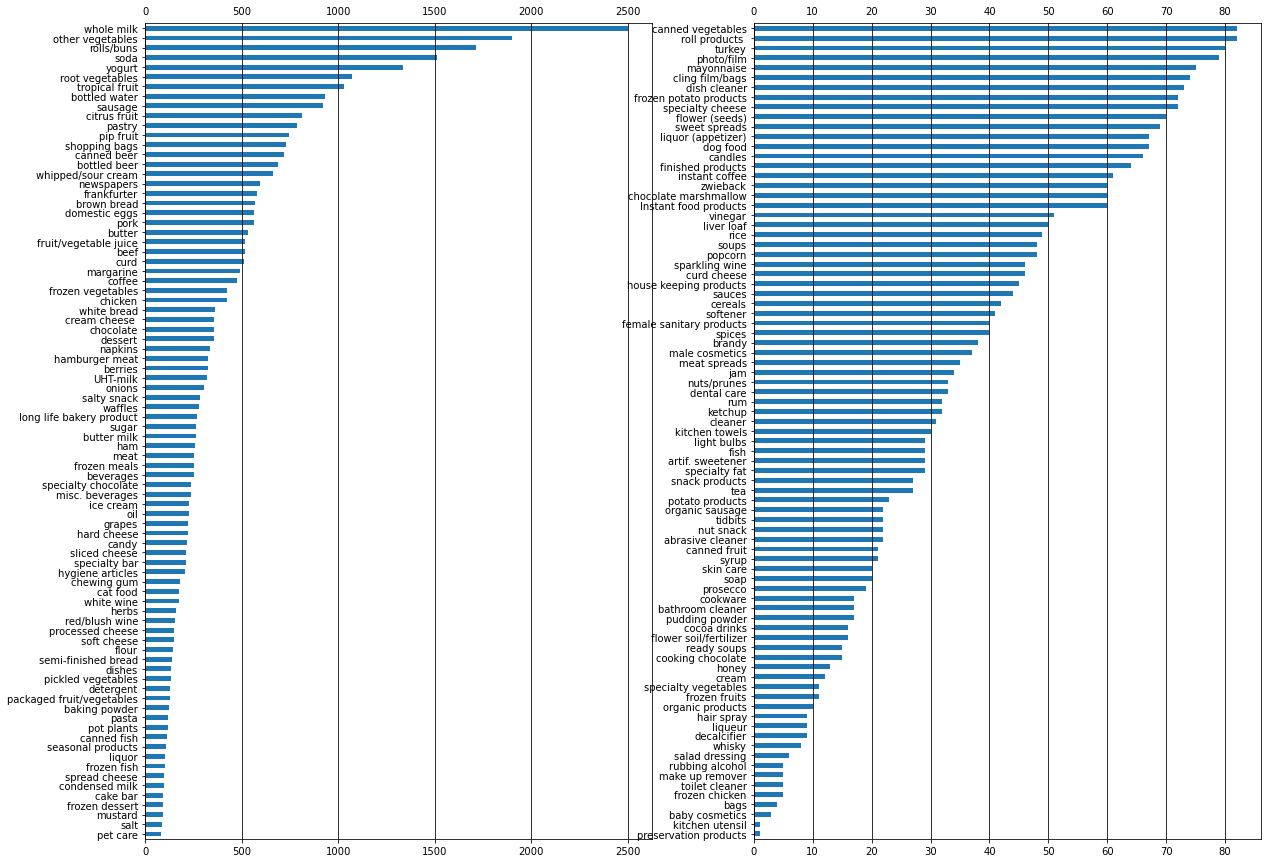

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(20, 15))

data["itemDescription"].value_counts().head(84).sort_values().plot(kind="barh", ax=ax[0])  # first half of items
data["itemDescription"].value_counts().tail(83).sort_values().plot(kind="barh", ax=ax[1])  # second half of items
ax[0].grid(axis="x", color="black")
ax[0].tick_params(labelbottom=True, labeltop=True)
ax[1].grid(axis="x", color="black")
ax[1].tick_params(labelbottom=True, labeltop=True)

We can see that by far most frequent product is whole milk, which existed in about 2500 transactions (16%). Other products, such as other vegetables, rolls/buns, soda, yogurt root vegetables and tropical fruits all were bought in over 1000 transactions. We can anticipate that these will be products present after creating association rules. When it comes to least frequent products we can see that thereare a lot of  products that were present in 100 or less transactions. Least frequent is preservation products and kitchen untensils which existed only in 1 transaction. Obviously there are a lot of products that I did not mention here, but the description above was intented to give you an idea how to look at these plots, and not comment on occurences of all items, as it would be pretty lengthy (167 products).

### Transform data to baskets

In this part I will transform data to look like baskets - rows will describe unique transactions and column will describe given item. If the item B existed in transaction A, it will be annotated as 1 a the intersection of row A and column B. This will give us a matrix which will be an input for apriori algorithm.

In [5]:
data_prep = data.copy()
data_prep["item"] = data_prep["itemDescription"]
data_prep["transaction"] = data_prep["Member_number"].astype(str) + " || " + data_prep["Date"]  # create unique transaction indicator as combination of date and customer number
data_prep.drop(axis=1, columns=["itemDescription", "Member_number", "Date"], inplace=True)  # drop unnecesary columns
data_prep["counter"] = 1  # counter equal to 1, as now each row describes one item purchased
data_prep.head()  # show the structure of data

,item,transaction,counter
0,tropical fruit,1808 || 21-07-2015,1
1,whole milk,2552 || 05-01-2015,1
2,pip fruit,2300 || 19-09-2015,1
3,other vegetables,1187 || 12-12-2015,1
4,whole milk,3037 || 01-02-2015,1


The transaction id was created from concatenating member number and date. This is a good way of identyfing transaction as there is low possiblity that given customer made many transaction on one day. This is an assumption that is necessary to conduct analysis with help of association rules and apriori algorithm. Also between member number and date, "<b>||</b>" was added so that if we want to split data later it will be helpful.

In [6]:
baskets = (data_prep
            .groupby(["transaction", "item"])["counter"]
            .sum()
            .unstack()
            .reset_index()
            .fillna(0)
            .set_index("transaction")
            )
print("Shape of baskets matrix:", baskets.shape)
baskets.head()  # 0 in row means that given item was not present in transaction

Shape of baskets matrix: (14963, 167)


item,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
transaction,,,,,,,,,,,,,,,,,,,,,
1000 || 15-03-2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1000 || 24-06-2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1000 || 24-07-2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000 || 25-11-2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000 || 27-05-2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
baskets.describe()

item,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
count,14963.000000,14963.000000,14963.000000,14963.000000,14963.000000,14963.000000,14963.000000,14963.000000,14963.000000,14963.000000,...,14963.000000,14963.000000,14963.000000,14963.000000,14963.000000,14963.000000,14963.000000,14963.000000,14963.000000,14963.000000
mean,0.004010,0.021587,0.001470,0.001938,0.000200,0.000267,0.008153,0.001136,0.034485,0.021854,...,0.005347,0.003408,0.018713,0.044242,0.000535,0.024193,0.011762,0.167212,0.089153,0.004010
std,0.063199,0.146707,0.038317,0.043983,0.014159,0.016348,0.090671,0.033689,0.185385,0.146668,...,0.072927,0.058284,0.136985,0.208224,0.023117,0.154953,0.108436,0.398805,0.296695,0.063199
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,2.000000,...,1.000000,1.000000,2.000000,2.000000,1.000000,2.000000,2.000000,4.000000,3.000000,1.000000


We can see above, that despite the fact that code for creating baskets works, there are some cells, where number of given item is greater than 1, and this is not allowed in python's apriori algorithm, so in next cell all values >= 1 are saved as 1; and all <= 0 as 0.

In [8]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_sets = baskets.applymap(encode_units)

## Apriori

### Support of itemsets

Below support values for itemsets are calculated and then value of their support is shown on bar plots. We set the support threshold to 0.5%, which gives us 126 frequent itemsets. This was mainly due to the fact, that higher values did not allow for rules (containing itemsets of multiple items) to appear. We can also see that there are not many pairs of products present based on support criterium - only after looking below 0.01 support we can observe itemsets comprised of more than 1 item. Based on plots below we can for example say that whole milk support is ~ 0.16, so it appears in 16% of transactions. Also when it comes to itemset of whole milk and soda - their support is close to 0.012, so they exist only in 1.2% of transactions. As for many of analysed itemsets value of support is low, there is possibility that no rules exists, or that created rules will have small values of important statistics. If that will be the case, the conclusion will be that in analysed dataset there are no association rules that we are confident with and it most likely should not be used as a recommendation system in produciton.

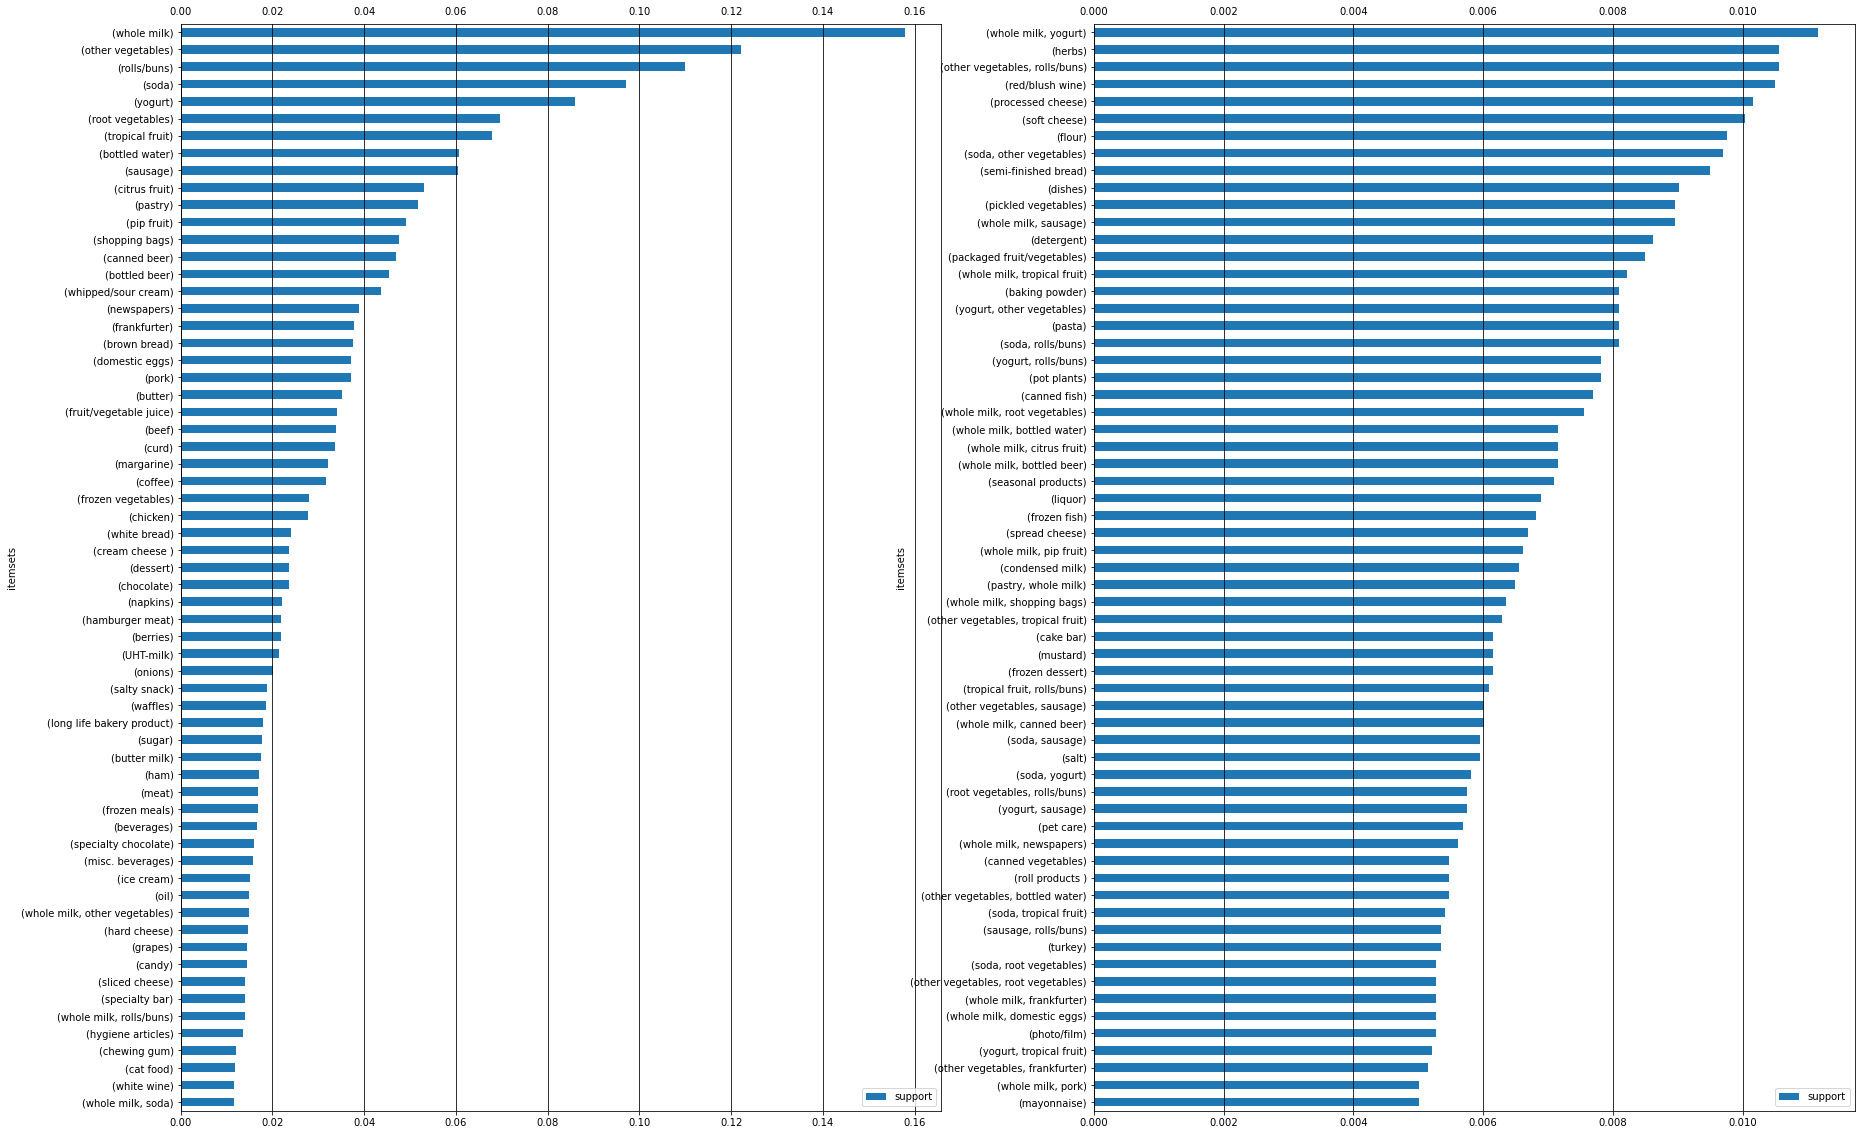

In [9]:
frequent_items = apriori(basket_sets, min_support=0.005, use_colnames=True)

frequent_items_to_plot = frequent_items.set_index("itemsets")
fig, ax = plt.subplots(1, 2, figsize=(30, 20))

frequent_items_to_plot.sort_values("support", ascending=False).head(63).sort_values("support").plot(kind="barh", ax=ax[0])  # 1 - 63 most frequent items
frequent_items_to_plot.sort_values("support", ascending=False).tail(63).sort_values("support").plot(kind="barh", ax=ax[1])  # 63 - 126 frequent items
ax[0].grid(axis="x", color="black")
ax[0].tick_params(labelbottom=True, labeltop=True)
ax[1].grid(axis="x", color="black")
ax[1].tick_params(labelbottom=True, labeltop=True)

### Rules

Below we can se rules made by the algorithm, which uses low confidence threshold value to allow me to comment on the results, as high value of threshold would result in no rules at all, as rules present in this dataset are insignificant. For every rules there are 5 evaluation metrics calculated:
 - <b>antecedent support [0,1]</b> - percent of transactions containing antecedent;
 - <b>consequent support [0,1]</b> - percent of transactions containing consequent;
 - <b>support [0,1]</b> - percent of transactions containing combined antecedent and consequent;
 - <b>confidence [0,1]</b> - probability of seeing the consequent in a transaction given that it also contains the antecedent - the higher, the better;
 - <b>lift [0, inf] </b> - how much more often the antecedent and consequent of a rule occur together, than we would expect if they were statistically independent. For independent rules it is equal to 1;
 - <b>leverage [-1, 1]</b> - the difference between the observed frequency of antecedent and consequent appearing together and the frequency that would be expected if antecedent and consequent were independent. For independent rules it is equal to 0;
 - <b>conviction [0, inf]</b> - for high conviction consequent is highly dependent on antecedent. 1) For independent items it is equal to 1. 2) For perfect score it is equal to infinity.

In [10]:
rules = association_rules(frequent_items, metric="confidence", min_threshold=0.05)  # set low threshold to analyse some patterns
rules.sort_values("confidence", ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(bottled beer),(whole milk),0.045312,0.157923,0.007151,0.157817,0.999330,-0.000005,0.999874
41,(sausage),(whole milk),0.060349,0.157923,0.008955,0.148394,0.939663,-0.000575,0.988811
8,(newspapers),(whole milk),0.038896,0.157923,0.005614,0.144330,0.913926,-0.000529,0.984114
5,(domestic eggs),(whole milk),0.037091,0.157923,0.005280,0.142342,0.901341,-0.000578,0.981834
7,(frankfurter),(whole milk),0.037760,0.157923,0.005280,0.139823,0.885388,-0.000683,0.978958
6,(frankfurter),(other vegetables),0.037760,0.122101,0.005146,0.136283,1.116150,0.000536,1.016420
23,(pork),(whole milk),0.037091,0.157923,0.005012,0.135135,0.855703,-0.000845,0.973652
22,(pip fruit),(whole milk),0.049054,0.157923,0.006616,0.134877,0.854071,-0.001130,0.973362
4,(citrus fruit),(whole milk),0.053131,0.157923,0.007151,0.134591,0.852259,-0.001240,0.973040
44,(shopping bags),(whole milk),0.047584,0.157923,0.006349,0.133427,0.844887,-0.001166,0.971732


#### Confidence-support-lift plot

On the plot below, I have plotted confidence against support, with color of points depicting lift value. We can see that there arenot many rules with  high support and high confidence, but other think to look at is lift, as we want it to be as high as it is possible. After looking at the plot and table with rules above we can conclude that we are not highly confident that the rules in this will occur in future  orders. Highest confidence rules is bottler beer followed by whole milk, which is not really a good rule, unless a lot of people buy beer with milk to treat hungovers. Also we can see that at chosen threshold there are no itemsets of more than 1 item. This could be because dataset is too small for apriori algorithm to detect meaningfull patterns, but still data from time period of almost 2 years and about 15k transactions should be enough, so it may point us towards conclusion that customers of this shop are behaving at random when it comes to purchases. Other explanation might be that the dataset comes from some kind of open street market where there is a lot of stands and customers buy various random things, therefore meaningfull paterns cannot be discovered.

<Figure size 720x360 with 0 Axes>

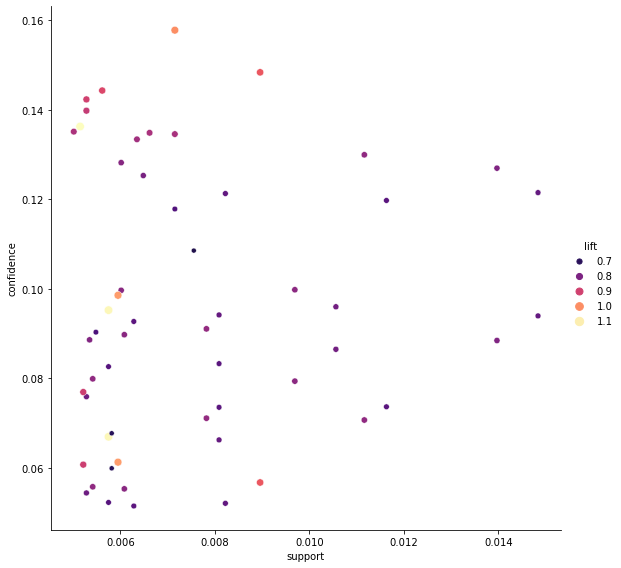

In [11]:
plt.figure(figsize=(10, 5))

sns.relplot(x="support", y="confidence", data=rules, size='lift', hue="lift", height=8, palette="magma")

#### Rules depicted with heatmap - based on confidence

Another good way to depict rules is to visualize them using heatmap. Below such plot is created and the brighter the colour, the  higher the value of confidence is. We can see that highest values of confidence are present in rules where whole milk is present. This indicated that whole milk, which is present in 16% is a most common product, and not necessarily means that it is a good rule.

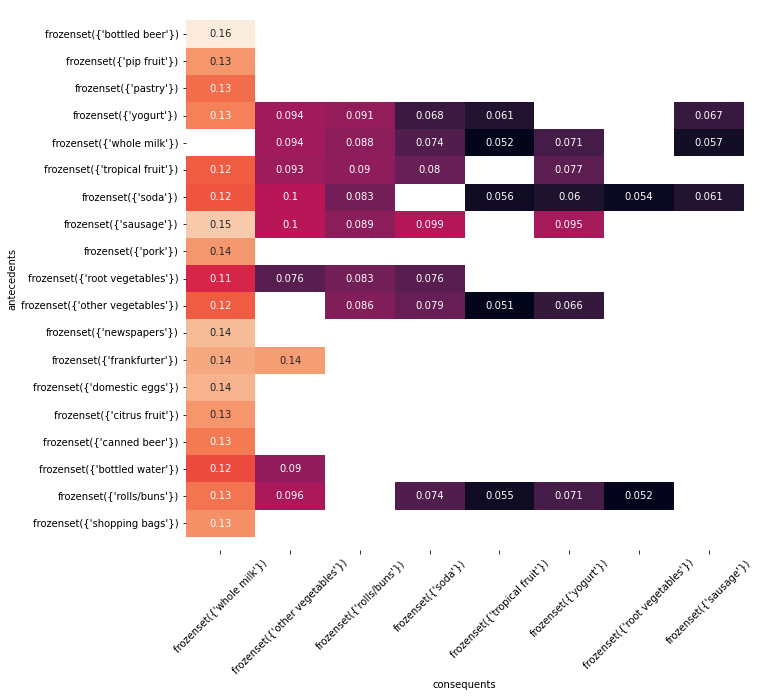

In [12]:
pivot = rules.pivot(index = 'antecedents', 
                    columns = 'consequents', values= 'confidence')

# Generate a heatmap with annotations on and the colorbar off
plt.figure(figsize=(10, 10))
sns.heatmap(pivot, annot = True, cbar = False)
b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t) 
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.show()

#### Parallel cordinates plot

Below I have created a parallel coordinates plot which visualises relationships between rule pairs. On the left side there are antecedents and on  the right consequents. We can see that most frequent consequent itemsets are other vegetables and whole milk -- as I said before, this most likely comes from the high support value of both these items in dataset.

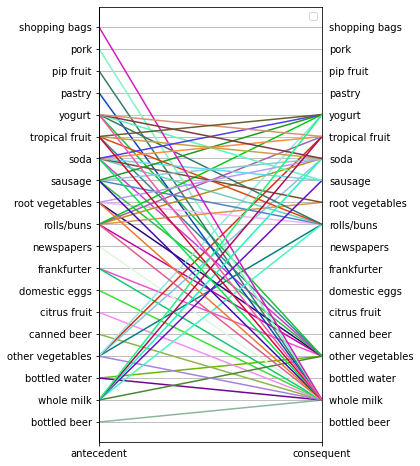

In [13]:
from pandas.plotting import parallel_coordinates


def rules_to_coordinates(rules):
    rules['antecedent'] = rules['antecedents'].apply(lambda antecedent: list(antecedent)[0])
    rules['consequent'] = rules['consequents'].apply(lambda consequent: list(consequent)[0])
    rules['rule'] = rules.index
    return rules[['antecedent','consequent','rule']]


coords = rules_to_coordinates(rules)

# Generate parallel coordinates plot
plt.figure(figsize=(4,8))
parallel_coordinates(coords, 'rule')
plt.legend([])
plt.grid(True)
plt.tick_params(labelleft=True, labelright=True)
plt.show()


## Summary

Firstly to summarise conducted analysis we need to say that although one might argue that there are rules in the detaset, they are definitely of low quality. While searching for some meaningful rules at threshhold of 5% of confidence, there are some rules that might make sense, but values of their lift, leverage and conviction are still pointing us towards rejecting these rules. I for example find rule containing newspapers as antecedent and whole milk as consequent as a pretty useful rule. This is because this might represent pattern of people making breakfast purchases - morning newspapers and some milk to drink or for cereals. Other convincing rule is bottled water --> vegetables, which is a good option for healthy people or rolls/buns --> whole milk which is another example of typical breakfast purchase. And while some of these rules make sense to me, there are a lot of that do not. For example bottled beer --> whole milk, frankfurter --> other vegetables or whole milk --> sausage which is definitely not common combination. 

Overall we can conclude that there were no significant rules found based on the 5% confidence criterium, which anyways is a small value as it basically describes probability of seing consequent, given antecedent. Also when looking at other values, such as lift, leverage and conviction it only gives more support to thesis that there are no rules in this dataset. And while it might be due to low number of transactions, which I do not believe is the case, we need to remember that data is spanned across 22 months, therefore obtaining data for a longer period may not improve these results, as customer's preferences change and so do rules.

## References
 - https://www.datacamp.com/community/tutorials/market-basket-analysis-r
 - http://rasbt.github.io/mlxtend/